# Creación modelos avanzados

En este cuaderno vamos a realizar algunas pruebas con nuestro nuevo dataset de forma que podamos comprobar la eficacia del nuevo dataset con los algoritmos que previamente habíamos probado y no habían funcionado bien

In [ ]:
# Imports
import pandas as pd
import numpy as np
import pickle


df = pd.read_csv('/content/sexism_data_balanced.csv')
df = df.dropna()
df.head()

,text,sexist
0,i didnt even know random was an option,False
1,bottom two shouldve gone,False
2,ladyboner deserves so much more credit than du...,False
3,she shall now be known as sourpuss,False
4,tarah w threw a bunch of women under the bus s...,False


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

stemmer = WordNetLemmatizer()
def lemmatization(text):
    
    text = text.split()
    text = [stemmer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df['text'] = df['text'].apply(lambda x: lemmatization(x))

In [ ]:
df.head()

,text,sexist
0,i didnt even know random wa an option,False
1,bottom two shouldve gone,False
2,ladyboner deserves so much more credit than du...,False
3,she shall now be known a sourpuss,False
4,tarah w threw a bunch of woman under the bus s...,False


## Prueba con TfidVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(max_features=400, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df['text'])
X.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(22436, 400)

In [ ]:
with open('/content/tfidfVectorizer', 'wb') as picklefile:
    pickle.dump(vectorizer,picklefile)

## Prueba con CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df['text'])
X.shape


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(13327, 500)

## Resto preprocesado

In [ ]:
y = df['sexist']
y = y.astype(int)
y.value_counts()

1    11220
0    11216
Name: sexist, dtype: int64

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## Árboles de decisión

La primera aproximación va realizarse con los árboles de decisión.

Usaremos la búsqueda de hiperparámetros para intentar obtener el mejor modelo posible


In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
classifierRFC = RandomForestClassifier(random_state=42)

param_gridRFC = { 
    'n_estimators': [1000, 1250, 1500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6, 8, 10, 12],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=classifierRFC, param_grid=param_gridRFC, cv= 5)
CV_rfc.fit(X_test, y_test)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 8, 10, 12],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1000, 1250, 1500]})

Obtenemos los resultados de la busqueda

In [ ]:
CV_rfc.cv_results_

In [ ]:
CV_rfc.best_estimator_

RandomForestClassifier(max_depth=12, max_features='log2', n_estimators=1500,
                       random_state=42)

Nos quedamos con el mejor estimador y lo guardamos

In [ ]:
bestRFC = CV_rfc.best_estimator_

In [ ]:
# Write
import pickle
with open('/content/bestRFC400Lem', 'wb') as picklefile:
    pickle.dump(bestRFC,picklefile)

In [ ]:
pred=bestRFC.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print('Accuracy Score:', accuracy_score(y_test, pred)) 

[[3475  241]
 [ 590 3098]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3716
           1       0.93      0.84      0.88      3688

    accuracy                           0.89      7404
   macro avg       0.89      0.89      0.89      7404
weighted avg       0.89      0.89      0.89      7404

Accuracy Score: 0.8877633711507293


**Análisis de features**

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html -> No muy expresivo

https://mljar.com/blog/feature-importance-in-random-forest/ -> Mejor

In [ ]:
vectorizer.get_feature_names_out()[:30]

array(['able', 'account', 'act', 'actually', 'adult', 'affair', 'aint',
       'alike', 'also', 'always', 'andre', 'annie', 'announcer',
       'another', 'ant', 'anyone', 'anything', 'arent', 'around', 'ask',
       'baby', 'back', 'bad', 'bang', 'basketball', 'bc', 'bed',
       'believe', 'best', 'better'], dtype=object)

Text(0.5, 0, 'Random Forest Feature Importance')

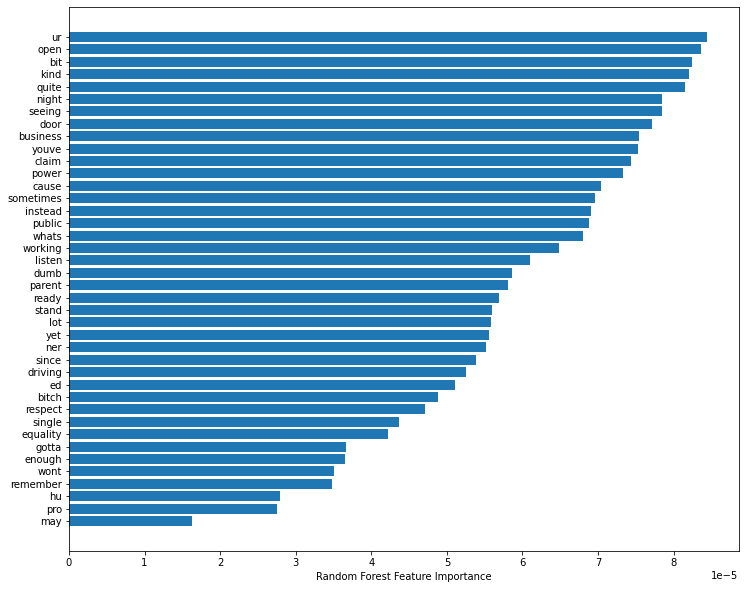

In [ ]:
import matplotlib.pyplot as plt

sorted_idx = bestRFC.feature_importances_.argsort()
sortedFeatures = vectorizer.get_feature_names_out()[sorted_idx]
sortedImportances = bestRFC.feature_importances_[sorted_idx]
plt.figure(figsize=(12, 10))
plt.barh(sortedFeatures[:40], sortedImportances[:40]) 
plt.xlabel("Random Forest Feature Importance")

## Regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression
classifierLR = LogisticRegression(max_iter=10000)

In [ ]:
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parametersLR = dict(C=C, penalty=penalty)

CV_lg = GridSearchCV(estimator=classifierLR, param_grid=parametersLR, cv= 5)
CV_lg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Sol

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.9636233...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [ ]:
CV_lg.cv_results_

In [ ]:
CV_lg.best_estimator_

LogisticRegression(C=0.5689866029018293, max_iter=10000)

In [ ]:
bestLG = CV_lg.best_estimator_

In [ ]:
# Write
import pickle

with open('/content/bestLG400Lem', 'wb') as picklefile:
    pickle.dump(bestLG,picklefile)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

predLG = bestLG.predict(X_test)

print(confusion_matrix(y_test, predLG))
print(classification_report(y_test, predLG))
print('Accuracy Score:', accuracy_score(y_test, predLG)) 

[[3395  321]
 [ 547 3141]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      3716
           1       0.91      0.85      0.88      3688

    accuracy                           0.88      7404
   macro avg       0.88      0.88      0.88      7404
weighted avg       0.88      0.88      0.88      7404

Accuracy Score: 0.882766072393301


Estudio de las features

In [ ]:
import numpy as np
coef = pd.DataFrame({"nombre_columna":vectorizer.get_feature_names_out (), 
                     "coeficientes" : bestLG.coef_[0]} )

coef.sort_values(by = "coeficientes", ascending=False)

,nombre_columna,coeficientes
25,char,7.309452
26,charwoman,7.199643
236,womanhood,6.974788
61,female,5.639785
40,distaff,5.257975
...,...,...
218,twitter,-1.991571
127,love,-2.117747
81,going,-2.197047
3,adult,-2.515212


Text(0.5, 0, 'Logistic Regression Importance (Negative Class)')

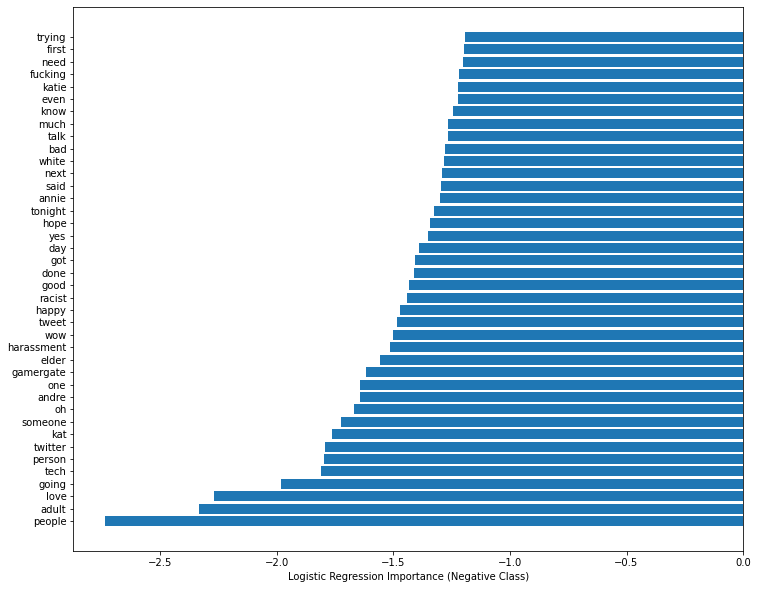

In [ ]:
import matplotlib.pyplot as plt

sorted_idx = bestLG.coef_[0].argsort()
sortedFeatures = vectorizer.get_feature_names_out()[sorted_idx]
sortedImportances = bestLG.coef_[0][sorted_idx]
plt.figure(figsize=(12, 10))
plt.barh(sortedFeatures[:40], sortedImportances[:40]) 
plt.xlabel("Logistic Regression Importance (Negative Class)")

Text(0.5, 0, 'Logistic Regression Importance (Possitive Class)')

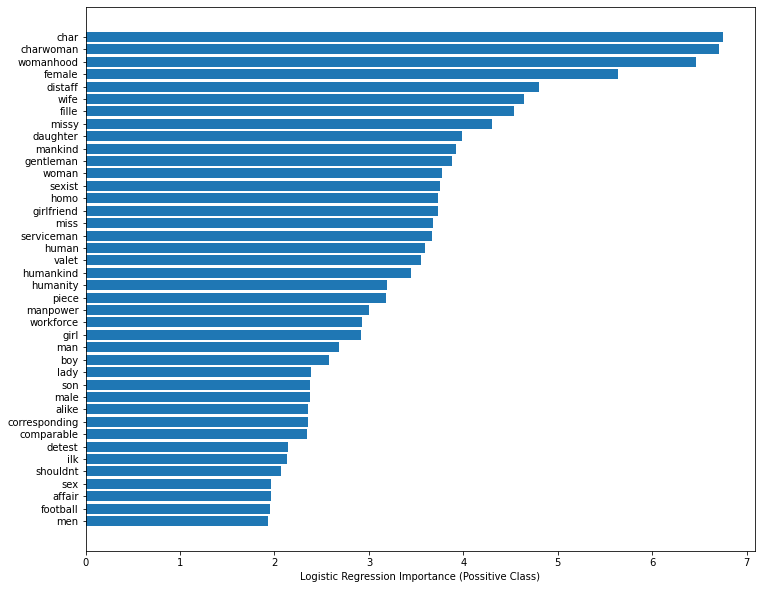

In [ ]:
plt.figure(figsize=(12, 10))
plt.barh(sortedFeatures[-40:], sortedImportances[-40:]) 
plt.xlabel("Logistic Regression Importance (Possitive Class)")


## Pruebas con los datos de prueba de internet

In [ ]:
# Texto machista
machista1 = "Err your quite cheap shows your upbringing was poor you’re jealous because I have everything and you don’t have a penny to your name"
machista2 = "I gather you are a single mother with 3 kids on benefits"
machista3 = "That's why woman single because depend on a man too much like don't depend on me if you want to go on a date invite me on"

# Texto no machista

nomachista1 = "At the minute I am just looking for any kind of work to get me out of the house"
nomachista2 = "Hundreds of people across Scotland, Northern Ireland and northern parts of England spotted an unusual fireball lighting up the night sky Wednesday"
nomachista3 = "The relatively early hour, plus clear night skies, meant that many people saw the fireball even in built-up areas such as Glasgow, O'Brien said"

# Creamos un dataframe basico
d = {'text': [machista1, machista2, machista3, nomachista1, nomachista2, nomachista3], 'sexist': [1, 1, 1, 0, 0, 0]}
dfTest = pd.DataFrame(data=d)

In [ ]:
dfTest

,text,sexist
0,Err your quite cheap shows your upbringing was...,1
1,I gather you are a single mother with 3 kids o...,1
2,That's why woman single because depend on a ma...,1
3,At the minute I am just looking for any kind o...,0
4,"Hundreds of people across Scotland, Northern I...",0
5,"The relatively early hour, plus clear night sk...",0


Preprocesado

In [ ]:
# Imports de preprocesamiento de textos
import re
import string

In [ ]:
# Auxiliar function for remove all emoji characters
# https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def removeEmoji(text):
    emoji_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"  # emoticons
      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
      u"\U0001F680-\U0001F6FF"  # transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
      u"\U00002500-\U00002BEF"  # chinese char
      u"\U00002702-\U000027B0"
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"
      u"\U0001f926-\U0001f937"
      u"\U00010000-\U0010ffff"
      u"\u2640-\u2642"
      u"\u2600-\u2B55"
      u"\u200d"
      u"\u23cf"
      u"\u23e9"
      u"\u231a"
      u"\ufe0f"  # dingbats
      u"\u3030"
      "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'',text)

# Preprocessor function
def preprocessor2(title_text):

    # Primero, segundo y cuarto, eliminiación de enlaces, menciones y hashtags - Incluimos eliminar espacios y caracteres raros
    title_text = title_text.apply(lambda x: re.sub(r'((https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b)|(MENTION[0-9]*)|(#[a-zA-Z0-9]*)', ' ', x, flags=re.MULTILINE))
    title_text = title_text.str.replace('\n',' ')
    title_text = title_text.str.replace('\t',' ')

    # Quitamos simbolos de puntuacion
    title_text = title_text.str.translate(str.maketrans('', '', string.punctuation))

    # Eliminamos los restos que no hayan sido eliminados y algunas expresiones que no aportan informacion
    title_text = title_text.apply(lambda x: re.sub(r'([^0-9a-zA-Z:,\s]+)|(rt)|(lol)|(lmao)|(lmfao)', '', x, flags=re.MULTILINE))

    # Despues de eliminar los simbolos de puntuacion, eliminamos los números
    title_text = title_text.apply(lambda x: re.sub(r'([0-9]+)', ' ', x, flags=re.MULTILINE))
    # Tercero, eliminiación de emojis
    title_text = title_text.apply(lambda x: removeEmoji(x))
    # Quitamos palabras sueltas con letras repetidas
    title_text = title_text.apply(lambda x: re.sub(r'(.)\1{3,}', ' ', x, flags=re.MULTILINE))

    # Ponemos todo en minusculas y aplicamos trim
    title_text = title_text.str.lower()
    title_text = title_text.str.strip()
    # Quitamos espacios sobrantes
    title_text = title_text.apply(lambda x: ' '.join([y for y in x.split(' ') if y != '']))

    # Lematizacion
    title_text = title_text.apply(lambda x: lemmatization(x))

    return title_text

In [ ]:
dfTest['text'] = preprocessor2(dfTest['text'])

In [ ]:
X_internet = vectorizer.transform(dfTest['text'])
X_internet.shape

(6, 400)

In [ ]:
X_internet

<6x400 sparse matrix of type '<class 'numpy.float64'>'
	with 32 stored elements in Compressed Sparse Row format>

In [ ]:
# Lectura
with open('/content/bestRFC600', 'rb') as training_model:
    bestRFC = pickle.load(training_model)

In [ ]:
# Lectura
with open('/content/bestLG', 'rb') as training_model:
    best_LG = pickle.load(training_model)

FileNotFoundError: ignored

In [ ]:
print(bestRFC.predict(X_internet))

[0 0 1 0 0 0]


In [ ]:
print(bestLG.predict(X_internet))

[0 0 0 0 0 0]
